In [1]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
# 1) 2H+ + I- + IO3- = HOI + HOIO         k1 = 1.43 x 10^3 M-3 s-1
# 2) H+ + HOIO + I- = 2HOI                k2 = 2.0 x 10^10 M-2 s-1
# 3) HOI + I- + H+ = I2 + H20             k3 = 3.1 x 10^12 M-2 s-1 and k-3 = 2.2 s-1
# 4) HOIO + IO3- + H+ = 2IO2 + H20        k4 = 7.3 x 10^3 M-2 s-1 and k-4 = 1.7 x 10^7 M-1 s-1
# 5) 2HOIO = HOI + I03- + H+              k5 = 6 x 10^5 M-1 s-1
# 6) IO2 + Mn2+ + H20 = HOIO + MnOH2+     k6 = 1.0 x 10^4 M-1 s-1
# 7) H202 + MnOH2+ = HOO + Mn2+ + H2O     k7 = 3.2 x 10^4 M-1 s-1
# 8) 2HOO = H202 + O2                     k8 = 7.5 x 10^5 M-1 s-1
# 9) I2 + MA = IMA + I- + H+              k9 = 40 M-1 s-1, C9 = 10^4 M-1
# 10) HOI + H202 = I- + O2 + H+ + H2O     k10 = 37 M-1 s-1

# x1   IO3-
# x2   I-
# x3   I2
# x4   HOIO
# x5   HOI
# x6   IO2
# x7   MnOH2+
# x8   HOO
# x9   MA
# x10  H202

def system(t, z):
    # Concentration assumptions
    h = 0.035
    A = 0.005
    
    # Reaction constants
    k1 = 1.43e3
    k2 = 2e10
    k3 = 3.1e12
    k3r = 2.2 # r3 reversed
    k4 = 7.3e3
    k4r = 1.7e7 # r4 reversed
    k5 = 6e5
    k6 = 1e4
    k7 = 3.2e4
    k8 = 7.5e5
    k9 = 40.0
    C9 = 1e4 # r9 second parameter
    k10 = 37.0
    
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = z
    v1 = k1 * h**2 * x2 * x1
    v2 = k2 * h * x4 * x2
    v3 = k3 * h * x5 * x2
    v3r = k3r * x3
    v4 = k4 * h * x1 * x4
    v4r = k4r * x6**2
    v5 = k5 * x4**2
    v6 = k6 * x6 * (A - x7)
    v7 = k7 * x7 * x10
    v8 = k8 * x8**2
    v9 = k9 * x9 * x3 / (1.0 + C9 * x3)
    v10 = k10 * x10 * x5
    dx1dt = (v4r + v5 - v1 - v4)
    dx2dt = (v3r + v9 + v10 - v1 - v2 - v3)
    dx3dt = (v3 - v3r - v9)
    dx4dt = (v1 + v4r + v6 - v2 - v4 - 2.0 * v5)
    dx5dt = (v1 + 2.0 * v2 + v3r + v5 - v3 - v10)
    dx6dt = (2.0 * v4 - 2.0 * v4r - v6)
    dx7dt = (v6 - v7)
    dx8dt = (v7 - 2.0 * v8)
    dx9dt = (-v9)
    dx10dt = (v8 - v7 - v10)
    return [dx1dt, dx2dt, dx3dt, dx4dt, dx5dt, dx6dt, dx7dt, dx8dt, dx9dt, dx10dt]

In [3]:
# Conditions initiales
z0 = [0.05, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.038, 0.88]

# Intervalle de temps sur lequel résoudre le système
t_span = (0, 2000)

# Points où résoudre la solution
t_eval = np.linspace(t_span[0], t_span[1], 20000)

# Résolution du système
sol = solve_ivp(system, t_span, z0, method='BDF', t_eval=t_eval, atol=1e-16, rtol=1e-13)
print(sol)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-01 ...  2.000e+03  2.000e+03]
        y: [[ 5.000e-02  5.619e-02 ...  4.380e-02  4.380e-02]
            [ 5.000e-03  2.457e-08 ...  3.354e-08  3.345e-08]
            ...
            [ 3.800e-02  3.798e-02 ...  1.801e-03  1.801e-03]
            [ 8.800e-01  8.780e-01 ...  8.651e-01  8.651e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 37487
     njev: 323
      nlu: 3210


In [4]:
def normalize_curves(curves):
    normalized_y = np.zeros_like(curves)  # Create an array of the same shape as the solution for storing normalized data
    for i in range(curves.shape[0]):  # Loop through each variable (row) in the solution
        min_val = np.min(curves[i])
        max_val = np.max(curves[i])
        if min_val == max_val:
            normalized_y[i] = curves[i] - min_val  # Adjusts the constant curve to zero
        else:
            normalized_y[i] = (curves[i] - min_val) / (max_val - min_val)  # Affine normalization
    return normalized_y
   
def apply_log10_to_curves(curves):
    log10_curves = np.zeros_like(curves)
    for i in range(curves.shape[0]):
        # Apply log10, ensuring no log(0) issue; adding a small number to avoid log(0)
        log10_curves[i] = np.log10(curves[i] + 1e-100)  # 1e-100 is arbitrary small number to avoid log(0)
    return log10_curves
   
curves = sol.y
curves = apply_log10_to_curves(curves)
curves = normalize_curves(curves)


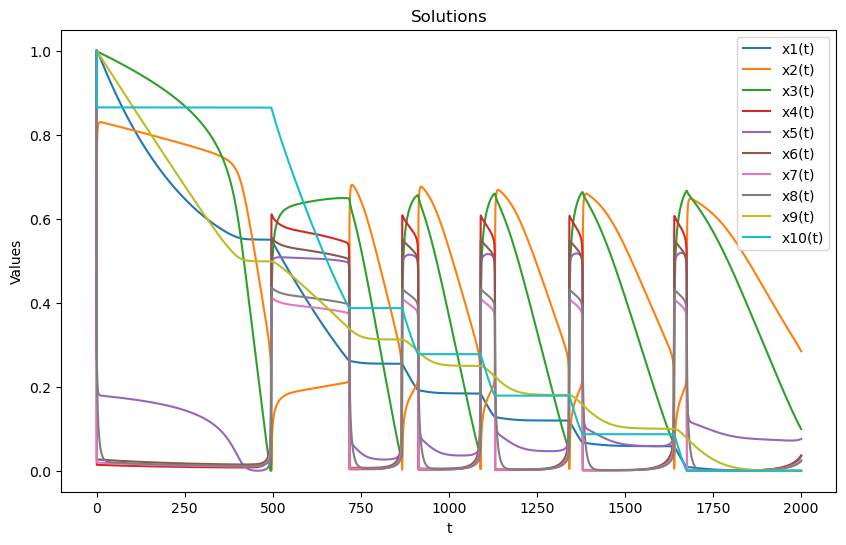

In [5]:
# Create checkboxes for each curve
checkboxes = [widgets.Checkbox(value=True, description=f'x{i+1}(t)') for i in range(curves.shape[0])]
button = widgets.Button(description="Plot Selected Curves")

# Function to plot curves based on checkbox status
def plot_selected_curves(b):
    plt.figure(figsize=(10, 6))
    for i, cb in enumerate(checkboxes):
        if cb.value:  # If the checkbox is checked, plot the curve
            plt.plot(sol.t, curves[i], label=f'x{i+1}(t)')
    plt.xlabel('t')
    plt.ylabel('Values')
    plt.legend()
    plt.title('Solutions')
    plt.show()

# Bind the button click event to the plotting function
button.on_click(plot_selected_curves)

# Display the checkboxes and the button
rows = [HBox(checkboxes[i:i+5]) for i in range(0, len(checkboxes), 5)]
# display(VBox(rows + [button])) # comment this line for myBinder
plot_selected_curves(0) # hack for myBinder
